# Project 5

### Fitting the Breit-Wigner Function, Electrostatic Potential Applications, 1D Wave Equation Exploration
 
#### Written by Owen Morehead - 5/14/2020


In [2]:
#Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


## Fitting the Breit-Wigner Function

The relativistic Breit-Wigner formula describes the resonances in neutron cross sections. 
Here we use these 'fake' data below and fit the Breit-Wigner function using Scipy's curve_fit(). We plot the data and the resulting fitted function below. 


In [2]:
# your code and results here
import scipy.optimize as sop
E = np.array([0., 25., 50., 75., 100., 125., 150., 175., 200.])    # input
y = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
err=np.array([.934, 1.79, 4.15, 8.55, 5.15, 2.15, 1.08, 6.29, 4.14 ])

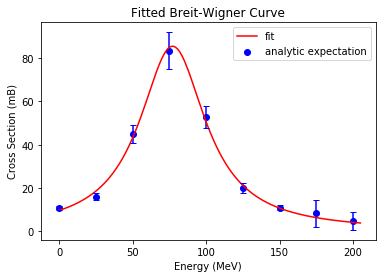

In [5]:
%matplotlib inline
#searching for best fit values of Er, fr, gam

def bw_funct(E,Er,fr,gam):
    return fr/((E-Er)**2 + gam**2/4)

popt,pcov = sop.curve_fit(bw_funct,E,y,sigma=err)
plt.plot(np.linspace(0,205,200),bw_funct(np.linspace(0,205,200),popt[0],popt[1],popt[2]),color='r',label='fit')
plt.scatter(E,y,color='blue',label='analytic expectation')
plt.errorbar(E,y,yerr=err,color='blue',fmt='none',marker='.',capsize=3,linestyle='none')
plt.title('Fitted Breit-Wigner Curve')
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross Section (mB)')
plt.legend()

Printing the resulting fit parameters ($E_r, f_r, \Gamma$) along with their errors, and the covariance matrix.

In [20]:
names = ['Er','fr','gam']
for i,name in zip(range(len(popt)),names):
    print('For parameter %s the value is %.3f +/- %.3f' %(name,popt[i],np.sqrt(pcov[i,i])))
    
print('The covariance matrix is:')
print(pcov)


For parameter Er the value is 77.249 +/- 1.086
For parameter fr the value is 64331.654 +/- 3322.967
For parameter gam the value is 54.837 +/- 2.873
The covariance matrix is:
[[1.18007587e+00 1.63896092e+02 3.68752397e-02]
 [1.63896092e+02 1.10421111e+07 7.64942616e+03]
 [3.68752397e-02 7.64942616e+03 8.25575986e+00]]


The off-diagonal elements in the covariance matrix represent the covariance between the two variables in the index. The matrix is symmetric in this regard, ie the covariance between x and y equals the covariance between y and x. As the covariance gets smaller, the less error there is between the parameters. We see the smallest values are in the xz and zx covariance. This means there is the least error between these parameters (Er and gam). The yz and zy covariance has the largest value and therefore there is more error between fr and gam. The xy and yx covariance also has a larger error between the parameters. as seen from the matrix elements. 

Assessing the quality of the fit with the reduced $\chi^2$. Two different methods to calculate it below.

In [23]:
def chi2(exp,theor,sig):
    c2 = 0.
    for i in range(len(theor)):
        c2 += (((bw_funct(E[i],popt[0],popt[1],popt[2])) - y[i])**2 / (err[i])**2)
    return c2

zz = chi2(y,bw_funct(E,popt[0],popt[1],popt[2]),err)
print('chi2 per degree of freedom is %2.2f' %(zz/(len(y) - 3)))


chi2 per degree of freedom is 0.68


In [27]:
def chi22(exp,theor,sig):
    return sum(((theor - exp)/sig)**2)

print('chi squared = %.3f' %(chi22(bw_funct(E,*popt),y,err) / (len(y)-3)))

chi squared = 0.677


This chi squared value is smaller than the ideal value of 1 and at first glance seems like a reasonable fit assuming reasonable error values for our data. We see a couple data points have much larger errors which contribute to this smaller chi squared value. To get an even more accurate value, more data should be taken. 

## Application: Electrostatic Potentials and Electric Fields
Recall, the solution for an electrostatic potential, $U$, satisfies Poisson's equation:

$$\nabla^2 U(\textbf{x}) = - 4 \pi \rho(\textbf{x})$$

Notice the $cgs$ units. If the region has no charge density, $\rho=0$, we have Laplace's equation.

Example: find the electric potential for all points inside a charge-free square.

The bottom and sides of the region are “grounded” (held at 0V). The top wire is connected to a voltage source that keeps it at 100 V. These provide a Dirichlet closed surface condition.

Working in cartesian coordinates:

$$\frac{\partial^2 U(x,y)}{\partial x^2}+ \frac{\partial^2
U(x,y)}{\partial y^2 } = - 4 \pi \rho(\textbf{x})$$

Skipping some steps we arrive at, 
Let $\Delta x = \Delta y = h$ (typically square grid): 

$${U(x+h,y) + U(x-h,y)}+ {U(x,y+h) +
U(x,y-h)- 4 U(x,y) } =  -4\pi\rho h^2$$
  
The solution for $U(x_i, y_j)$ is 

$$\boxed{U_{i,j} =\frac{1}{4} \left[U_{i+1,j}+U_{i-1,j}
 + U_{i,j+1} + U_{i,j-1} \right]+ \pi\rho_{i,j}h^2}$$
 

When $\rho=0$, a solution to Laplace's equation has the property that the value at any point is equal to the average value over a sphere of any radius (contained in the region) centered at that point. 

Let us accordingly construct an iterative algorithm:
* initialize: guess the values for every point in the grid.
* walk: replace each point's value by the average of the nearest neighbor values
* iterate to convergence

Otherwise known as "relaxation" to the solution. Relaxation iterations will stop when the solution has convereged to a certain tolerance.


[257153, 186201, 75114, 10863]


Text(0, 0.5, 'Number of Iterations')

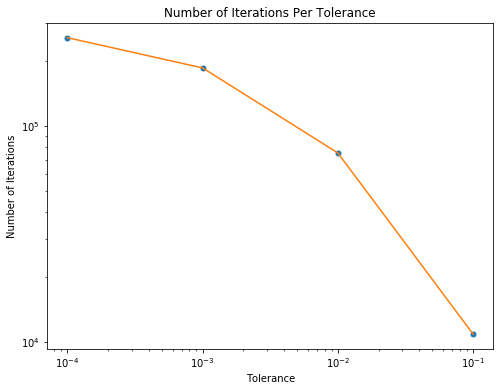

In [9]:
%matplotlib inline
#from mpl_toolkits.mplot3d import Axes3D 

Nmax = 100
Niter = 100

def iterator(tol):
    """Function that runs the iterations over algorithm
    """
    V=np.zeros([100,100])
    V[0,:]=100   #fixed potential line at 100V
    trial=1      #value that will represent the number of steps for each tolerance level
    for iter in range(Niter):
        for i in range(1,Nmax-1):
            for j in range(1,Nmax-1):
                orig=V[i,j]
                V[i,j]= .25*(V[i+1,j]+V[i,j+1]+V[i-1,j]+V[i,j-1])
                change=abs(orig-V[i,j])

                if change>tol:
                    trial+=1
                    continue
                if change<=tol:
                    break
                       
    return trial,V

x = range(0,Nmax)
y = range(0,Nmax)
X,Y = np.meshgrid(x,y)

#def functz(V):
#    z = iterator(10**-3)[1][X,Y]
#    return z
#Z = functz(V)

def functz(V):
    z = V[X,Y]
    return z
Z = functz(iterator(10**-4)[1])

#commented out code below is to plot the 3d potential plot
"""
fig = plt.figure()                              # Create figure
ax = Axes3D(fig)                                # plot axes
ax.plot_wireframe(X, Y, Z, color = 'r', rstride=5, cstride=1,alpha=.8)  # red wireframe, setting the stride values explicitly
ax.set_xlabel('X')                              # label axes
ax.set_ylabel('Y')
ax.set_zlabel('Potential U')
plt.show()  
"""


ns = [4,3,2,1]
xval=[10**-n for n in ns]
yval=[iterator(10**-n)[0] for n in ns]
print(yval)
#print(iterator(10**-1)[0])
plt.figure(figsize=(8,6))
plt.plot(xval,yval,'.',markersize=10)
plt.plot(xval,yval)
plt.xscale('log')
plt.yscale('log')

plt.title('Number of Iterations Per Tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Number of Iterations')







Drawing equipotential contours

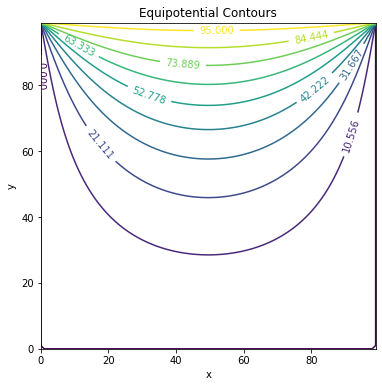

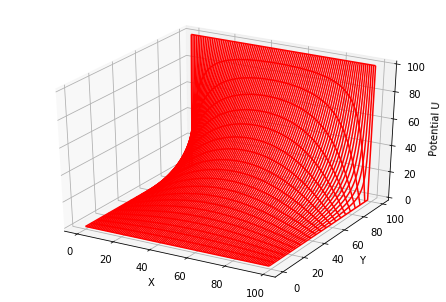

In [10]:
Nmax=100
Niter=100
def iterator2(tol):
    V=np.zeros([100,100])
    V[:,-1]=100
    trial=1
    next_iter=True    #while loop method of running the iteration algorithm. 
                      
    while next_iter==True: 
        next_iter=False
        for i in range(1,Nmax-1):
            for j in range(1,Nmax-1):
                orig=V[i,j]
                V[i,j]=.25*(V[i+1,j]+V[i,j+1]+V[i-1,j]+V[i,j-1])
                change=abs(orig-V[i,j])
                if change>tol:
                    next_iter=True
                    trial+=1
              
    return V
      



x = range(0, Nmax)
y = range(0, Nmax)
X, Y = np.meshgrid(x,y)  
def functz(V):                                  # Function returns V(x, y)
    z = V[X,Y]                        
    return z
Z=functz(iterator2(10**-3))

fig,ax=plt.subplots(figsize=(6,6))
plt.title('Equipotential Contours')
h=np.linspace(0,95,10)
CS = ax.contour(X, Y, Z,levels=h)
ax.clabel(CS)
plt.ylabel('y')
plt.xlabel('x')



fig = plt.figure()                              # Create figure
ax = Axes3D(fig)                                # plot axes
ax.plot_wireframe(X, Y, Z, color = 'r', rstride=5, cstride=1)  # red wireframe, setting the stride values explicitly
ax.set_xlabel('X')                              # label axes
ax.set_ylabel('Y')
ax.set_zlabel('Potential U')
plt.show() 

Comparaing results with the analytic expression given by: 
$$U(x,y) = \sum_{n=1,3,5,\dots}^\infty \frac{400}{n\pi} \sin\left( \frac{n\pi x}{L} \right) \frac{\sinh(n\pi y/L)}{\sinh(n\pi)}$$

Text(0, 0.5, 'y')

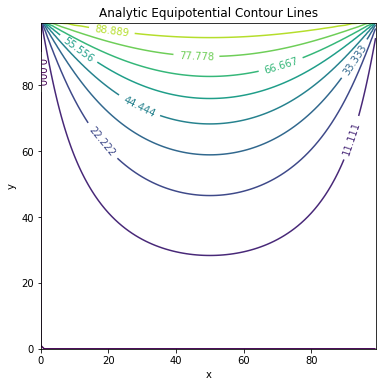

In [15]:
Nmax=100
x = range(0, Nmax)
y = range(0, Nmax)
X, Y = np.meshgrid(x,y) 

def analytic_soln(max_n,L,x,y):
    """Function computes the analytic potential with max_n terms in the summation
    """
    ns = np.arange(1,max_n,2) #count every other n value, hence only odd values
    return np.sum([400/(n*np.pi)*np.sin(n*np.pi*x/L)*np.sinh(n*np.pi*y/L)/(np.sinh(n*np.pi)) for n in ns],axis=0)
    


U_analytic = analytic_soln(50,100,X,Y)

fig,ax=plt.subplots(figsize=(6,6))
plt.title('Analytic Equipotential Contour Lines')
h=np.linspace(0,100,10)
cs = ax.contour(X, Y, U_analytic,levels=h)
ax.clabel(cs)
plt.xlabel('x')
plt.ylabel('y')


Text(0, 0.5, 'y')

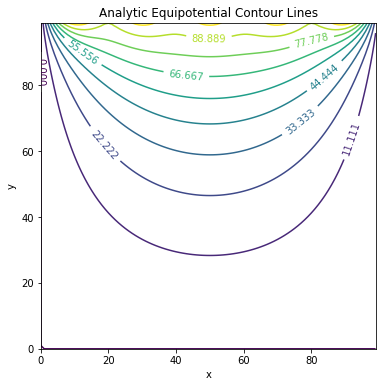

In [14]:
Nmax=100
x = range(0, Nmax)
y = range(0, Nmax)
X, Y = np.meshgrid(x,y) 

def analytic_soln(max_n,L,x,y):
    """Function computes the analytic potential with max_n terms in the summation
    """
    ns = np.arange(1,max_n,2) #count every other n value, hence only odd values
    return np.sum([400/(n*np.pi)*np.sin(n*np.pi*x/L)*np.sinh(n*np.pi*y/L)/(np.sinh(n*np.pi)) for n in ns],axis=0)
    


U_analytic = analytic_soln(10,100,X,Y)

fig,ax=plt.subplots(figsize=(6,6))
plt.title('Analytic Equipotential Contour Lines')
h=np.linspace(0,100,10)
cs = ax.contour(X, Y, U_analytic,levels=h)
ax.clabel(cs)
plt.xlabel('x')
plt.ylabel('y')



We see that when using less summation terms, the contour lines for larger levels are more curvy and the potential is not as accurate as with more terms. 

Otherwise, exact same contour plot as the numerical solution.

## Electrostatic Potential Applications Continued
A large, thin metal plate has a 9cm x 9cm square hole cut in it, and a 3cm x 3cm square plate is placed in the middle of the hole. The inner plate is held at ground (0 volts), and the outer plate is at +100 volts.

Here we calculate and show in a wireframe plot the electrostatic potential in the region between the plates.

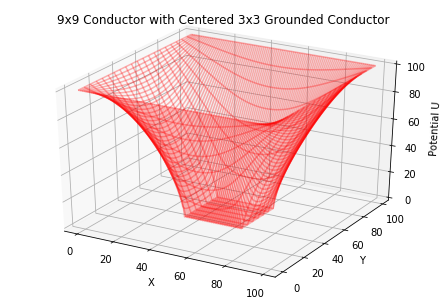

In [27]:
from itertools import chain
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib inline

def iterator(tol,nmax):
    V=np.zeros([nmax,nmax])
    V[0,:]=100   #setting the outer plate sides to 100V
    V[:,-1]=100
    V[:,0]=100
    V[-1,:]=100
    next_run=True  #variable to control iterations depending on tolerance cutoff
    while next_run:  #keep running this loop while next_run=True
        next_run=False    #this statement will stay false unless our change is greater than tolerance specified
        for i in (range(1,nmax-1)):
            for j in (range(1,nmax-1)):
                if i> int(nmax/2-nmax/6) and i< int(nmax/2+nmax/6) and j> int(nmax/2-nmax/6) and j< int(nmax/2+nmax/6):
                    continue   #continue for values of i and j in the region specified
                original=V[i,j]   
                #print(V)
                V[i,j]=0.25*(V[i+1,j]+V[i,j+1]+V[i-1,j]+V[i,j-1])
                change=abs(original-V[i,j])   #calculate change for tolerance comparison
                
                if change>tol:
                    next_run=True
    return V

nmax=100
x = range(0, nmax)
y = range(0, nmax)
X, Y = np.meshgrid(x,y)          
V= iterator(10**-2,nmax)
#print (V[55,55])

def functz(V):                                  # Function returns V(x, y)
    z = V[X,Y]                        
    return z

Z = functz(V)                          
fig = plt.figure()                              # Create figure
ax = Axes3D(fig)                                # plot axes
ax.plot_wireframe(X, Y, Z, color = 'r', rstride=5, cstride=1,alpha=.3)  # red wireframe, setting the stride values explicitly
ax.set_xlabel('X')                              # label axes
ax.set_ylabel('Y')
ax.set_title('9x9 Conductor with Centered 3x3 Grounded Conductor')
ax.set_zlabel('Potential U')
plt.show()  

Drawing the equipotential contours with the electric field lines.

$$(\vec{E}_{ij})_x = -\frac{U_{i+1,j}-U_{i-1,j}}{2\Delta x}$$

$$(\vec{E}_{ij})_y = -\frac{U_{i,j+1}-U_{i,j-1}}{2\Delta y}$$

Below I utilize np.gradient to find the electric field values.

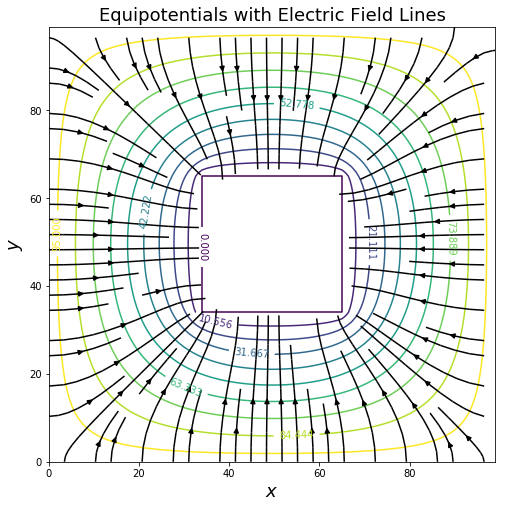

In [30]:
#Equipotential Contours with Electric Field Lines
#calculating Electric Field with Gradient Function

%matplotlib inline
#plt.contour(X,Y,Z)
#plt.contour(X,Y,functz(np.array(U)))

fig,ax=plt.subplots(figsize=(8,8))
plt.title('Equipotentials with Electric Field Lines',size=18)
h=np.linspace(0,95,10)
#h = [0,5,15,50,75,95]
CS = ax.contour(X, Y, Z,h)
ax.clabel(CS)
plt.xlabel('$x$',size=18)
plt.ylabel('$y$',size=18)

Z=functz(V)
E=np.gradient(-Z)
E=np.array(E)
plt.streamplot(X,Y,E[1],E[0],color='black')



Notice the electric field inside the plate is zero as expected. In addition, since the electric field lines point radially away from the charged plate, they are perpendicular to the equipotential lines.

## Wave Equation in 1 Dimension

The basic form of this Partial Differential Equation is of the form:

$$\frac{1}{c^2}\frac{\partial^2 f}{\partial t^2} - \frac{\partial^2 f}{\partial x^2} = 0$$

If we consider a stretched string fixed at two endpoints with linear mass density $\mu$ and tension $T$, we can arrive at the form of a wave equation with wave velocity $c = \sqrt{T/\mu}$:

$$\frac{\partial^2 y(x,t)}{\partial x^2} = \frac{\mu}{T} \frac{\partial^2 y(x,t)}{\partial t^2}$$

Note we only consider linear wave equations: $\theta$ is small enough so that $\sin\theta \simeq \tan\theta =\partial y/\partial x$. And as always, we need to consider the boundary conditions. 

Let us derive the solution analytically for good measure:

### Analytic Solution

Separation of variables: 

$$y(x,t) = X(x)T(t)$$

leading to

$$\frac{d^2 T(t)}{dt^2} +\omega^2 T(t) = 0, \quad \frac{d^2
X(x)}{dx^2} +k^2 X(x) = 0,\quad c { = } \frac{\omega}{k}$$

and each of these equations has its own boundary conditions that must be satisfied.

#### Spatial part

There are infinitely many solutions, indexed by $n$.  Each mode $n$ has a different wavenumber $k_n$.
The spatial solution $X(x)$ has the general solution

$$X_n(x) = A_n \sin {k_n x} + D_n \cos {k_n x}, \quad k_n = \frac {\pi (n+1) } {L}, \quad n = 0, 1, \ldots$$

If the **initial condition** is that the string is fixed at the ends ($x=0,L$), then $D_n =0$ for all of the coefficients.

#### Temporal part

There are also infinitely many solutions, indexed by $n$.  Each mode $n$ has a different frequency $\omega_n$:

$$T_n(t) = C_n \sin \omega_n t + D_n \cos \omega_n t, \quad
\omega_n = n  c k_0 = n \frac{2\pi c}{L}$$

If the **initial condition** is that the string is released from rest ($\partial y/\partial t$), then the $C_n$ must all be 0, and the $D_n$ can be absorbed into the definition of the $B_n$ when the spatial and temporal parts are put together: 

$$y(x,t) = \sum_{n=0}^\infty B_n \sin k_nx \cos \omega_n t, \quad n=0, 1,
\ldots$$

### Numerical Solution

As with other PDEs, we can use the central-difference approximations (aka midpoint algorithm) for the second derivatives to convert the differential wave equation into a finite difference equation, and use a grid of $x$ and $t$ values to solve the equations.

$$\frac{\partial^2 y }{\partial t^2} \simeq
\frac{y_{i,j+1}+y_{i,j-1}-2 y_{i,j}}{(\Delta t)^2}, \quad
\frac{\partial^2 y}{\partial x^2} \simeq \frac{y_{i+1,j}
+y_{i-1,j}-2 y_{i,j}} {(\Delta x)^2}$$

These can be substituted into the differential equation to obtain the finite difference equation:

$$
\frac{y_{i,j+1}+y_{i,j-1}-2 y_{i,j}} {c^2 (\Delta t)^2}  =
\frac{y_{i+1,j}+y_{i-1,j}-2 y_{i,j}} {(\Delta x)^2}$$

Notice that this equation contains three time values: 
* $j+1 = $ "the future," 
* $j  = $ "the present," and 
* $j - 1 = $ "the past." 

Rearrange to get the future value in terms of current or prior values (aka "explicit" method):

$$\boxed{y_{i,j+1}  = 2 y_{i,j}-y_{i,j-1}+ \frac{c^2 }
{C'^{2}} \left [ y_{i+1,j}+y_{i-1,j}-2 y_{i,j}\right]},$$

where $C'\equiv \frac {\Delta x}{\Delta t}$ is a combination of algorithm parameters with the dimension of velocity whose size relative to $c$ determines the stability of the
algorithm. (As discussed and shown in lecture, we need $c/C' \le 1$ for stability.)
 
### Plucked String Example

We set one initial condition for each point (velocity $dy/dt=0$).
The second initial condition for each point is given by the initial position of each piece of string.
The "pluck" in this case brings one point in the string (at $0.8L$) to 0.1 m from the equilibrium position.
That pluck causes the string to assume an initial position $(y\neq 0)$ everywhere, except the ends.


0.6262556015780532


<IPython.core.display.Javascript object>


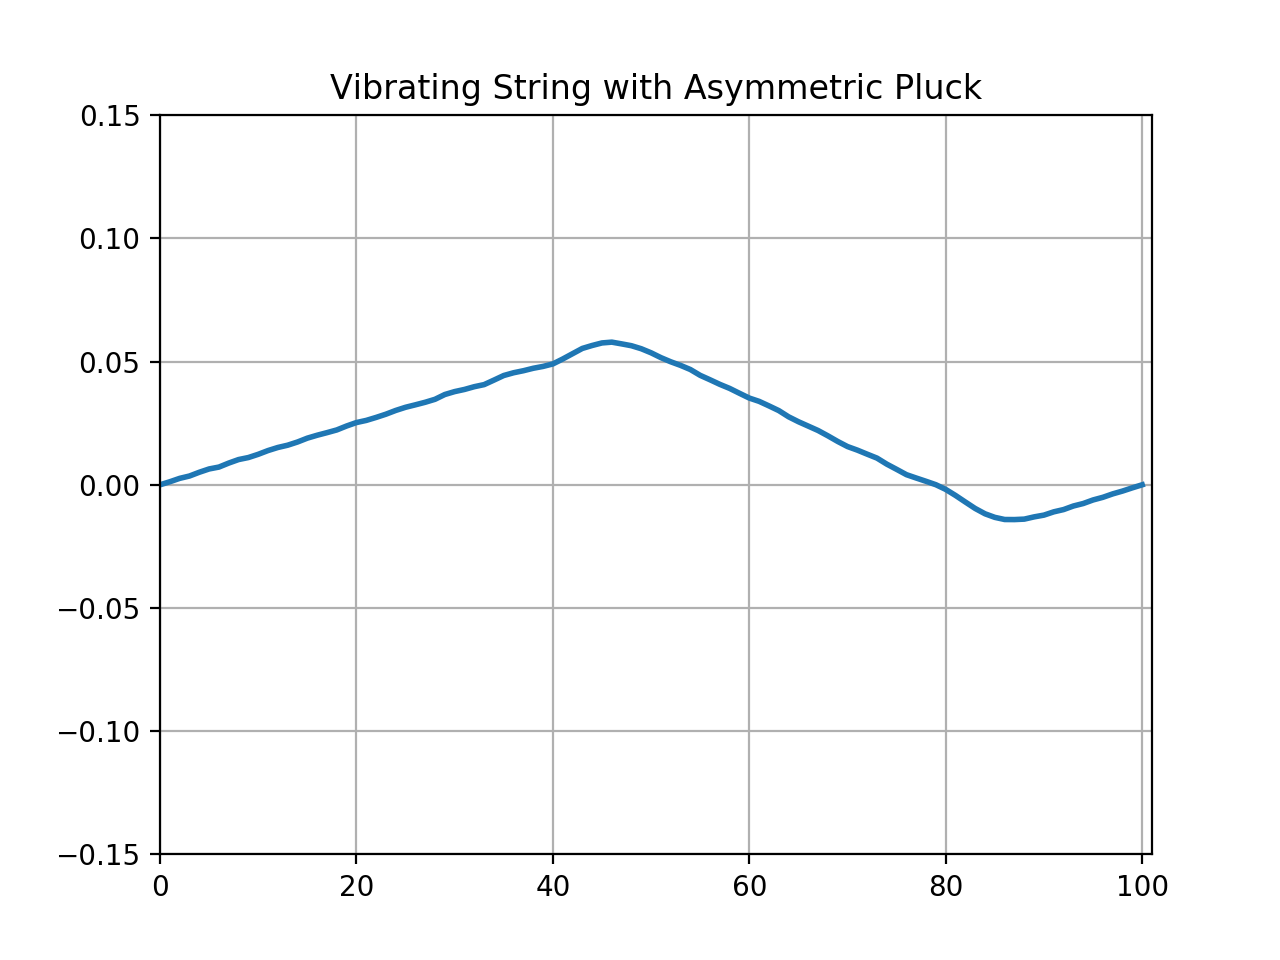

finished


In [4]:
#### EqStringAnimate.py, Notebook Version, Vibrating string using MatPlotLib animation
%matplotlib notebook
import matplotlib.animation as animation

# Parameters
N = 101
L=100        #length input parameter
x=np.linspace(0,L,N)    #x, steps array
t=np.linspace(0,100,N*100)    #t, steps array
delx=x[1]-x[0]     #calculating delta x for Courant condition
delt=t[1]-t[0]     #calculating delta t for Courant condition
mu = 0.01                               # string density
ten = 40.                               # string tension
c = np.sqrt(ten/mu)                     # propagation speed
c1 = delx/delt    #CFL criterion
print (c/c1)      #g^n(k) \leq 1. Stability defining ratio.
ratio =  c*c/(c1*c1)

# Initialization
xi = np.zeros( (N, 3), float)           # N x's & 3 t's to save memory (only need 3 time terms for algorithm)
k=range(0,N)
ipluck=0.8
def init():
    for i in range(0, int(ipluck*N)):
        xi[i, 0] = 0.1*i/int(ipluck*N)          # Initial condition: string plucked,shape
    for i in range (int(ipluck*N), N):                           # first part of string
        xi[i, 0] = 0.1 - 0.1/(N*(1-ipluck))*(i - int(ipluck*N))                 # second part of string

init()                                     # plot string initial position   
fig=plt.figure()                           # figure to plot (a changing line)
# select axis; 111: only one plot, x,y, scales given
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, N), ylim=(-0.15, 0.15))
ax.grid()                                                       # plot a grid
plt.title("Vibrating String with Asymmetric Pluck")
line, = ax.plot(k, xi[k,0], lw=2)             # x axis, y values, linewidth=2     

# Later time steps   CORE ALGORITHM
for i in range(1, N-1):                                      # use  algorithm
    xi[i, 1] = xi[i, 0] + 0.5*ratio*(xi[i + 1, 0] + xi[i - 1, 0] - 2*xi[i, 0])   

def animate(num):               #num: dummy,  algorithm, will plot (x, xi)            
    for i in range(1, N-1):              
        xi[i,2] = 2.*xi[i,1]-xi[i,0]+ratio*(xi[i+1,1]+xi[i-1,1]-2*xi[i,1])
    line.set_data(k,xi[k,2])                              # data to plot ,x,y           
    for m in range (0,N):                               # part of algorithm
        xi[m, 0] = xi[m, 1]                               # recycle array 
        xi[m, 1] = xi[m, 2]
    return line,
# next: animation(figure, function,dummy argument: 1      
ani = animation.FuncAnimation(fig, animate,1)           
plt.show()             
print("finished")

We see that this pluck is asymmetric and behaves as expected. Moving from the pluck origin on the right to the left and then back as it bounces of the zero velocity endpoint.

Changing the initial condition to be that of a standing wave:

0.6262556015780532


<IPython.core.display.Javascript object>


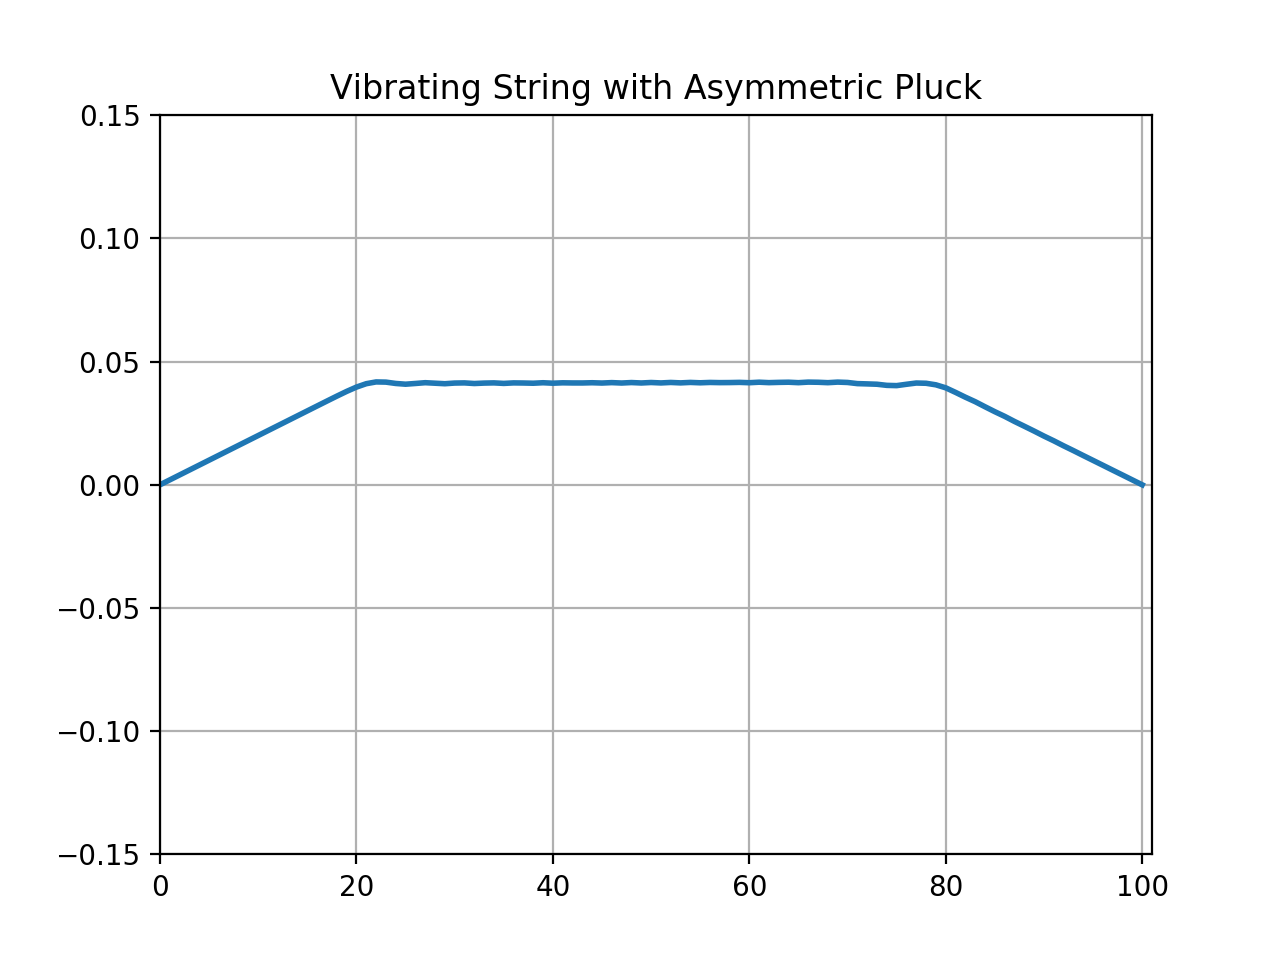

finished


In [5]:
#Symmetric pluck

%matplotlib notebook
import matplotlib.animation as animation

# Parameters
N = 101
L=100        #length input parameter
x=np.linspace(0,L,N)    #x, steps array
t=np.linspace(0,100,N*100)    #t, steps array
delx=x[1]-x[0]     #calculating delta x for Courant condition
delt=t[1]-t[0]     #calculating delta t for Courant condition
mu = 0.01                               # string density
ten = 40.                               # string tension
c = np.sqrt(ten/mu)                     # propagation speed
c1 = delx/delt    #CFL criterion
print (c/c1)      #g^n(k) \leq 1. Stability defining ratio.
ratio =  c*c/(c1*c1)

# Initialization
xi = np.zeros( (N, 3), float)           # N x's & 3 t's to save memory (only need 3 times for algorithm)
k=range(0,N)
ipluck=0.5     #pluck in center of string causes standing wave behavior
def init():
    for i in range(0, int(ipluck*N)):
        xi[i, 0] = 0.1*i/int(ipluck*N)          # Initial condition: string plucked,shape
    for i in range (int(ipluck*N), N):                           # first part of string
        xi[i, 0] = 0.1 - 0.1/(N*(1-ipluck))*(i - int(ipluck*N))                 # second part of string

init()                                     # plot string initial position   
fig=plt.figure()                           # figure to plot (a changing line)
# select axis; 111: only one plot, x,y, scales given
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, N), ylim=(-0.15, 0.15))
ax.grid()                                                       # plot a grid
plt.title("Vibrating String with Asymmetric Pluck")
line, = ax.plot(k, xi[k,0], lw=2)             # x axis, y values, linewidth=2     

# Later time steps   CORE ALGORITHM
for i in range(1, N-1):                                      # use  algorithm
    xi[i, 1] = xi[i, 0] + 0.5*ratio*(xi[i + 1, 0] + xi[i - 1, 0] - 2*xi[i, 0])   

def animate(num):               #num: dummy,  algorithm, will plot (x, xi)            
    for i in range(1, N-1):              
        xi[i,2] = 2.*xi[i,1]-xi[i,0]+ratio*(xi[i+1,1]+xi[i-1,1]-2*xi[i,1])
    line.set_data(k,xi[k,2])                              # data to plot ,x,y           
    for m in range (0,N):                               # part of algorithm
        xi[m, 0] = xi[m, 1]                               # recycle array 
        xi[m, 1] = xi[m, 2]
    return line,
# next: animation(figure, function,dummy argument: 1      
ani = animation.FuncAnimation(fig, animate,1)           
plt.show()             
print("finished")

0.9634701562739278


<IPython.core.display.Javascript object>


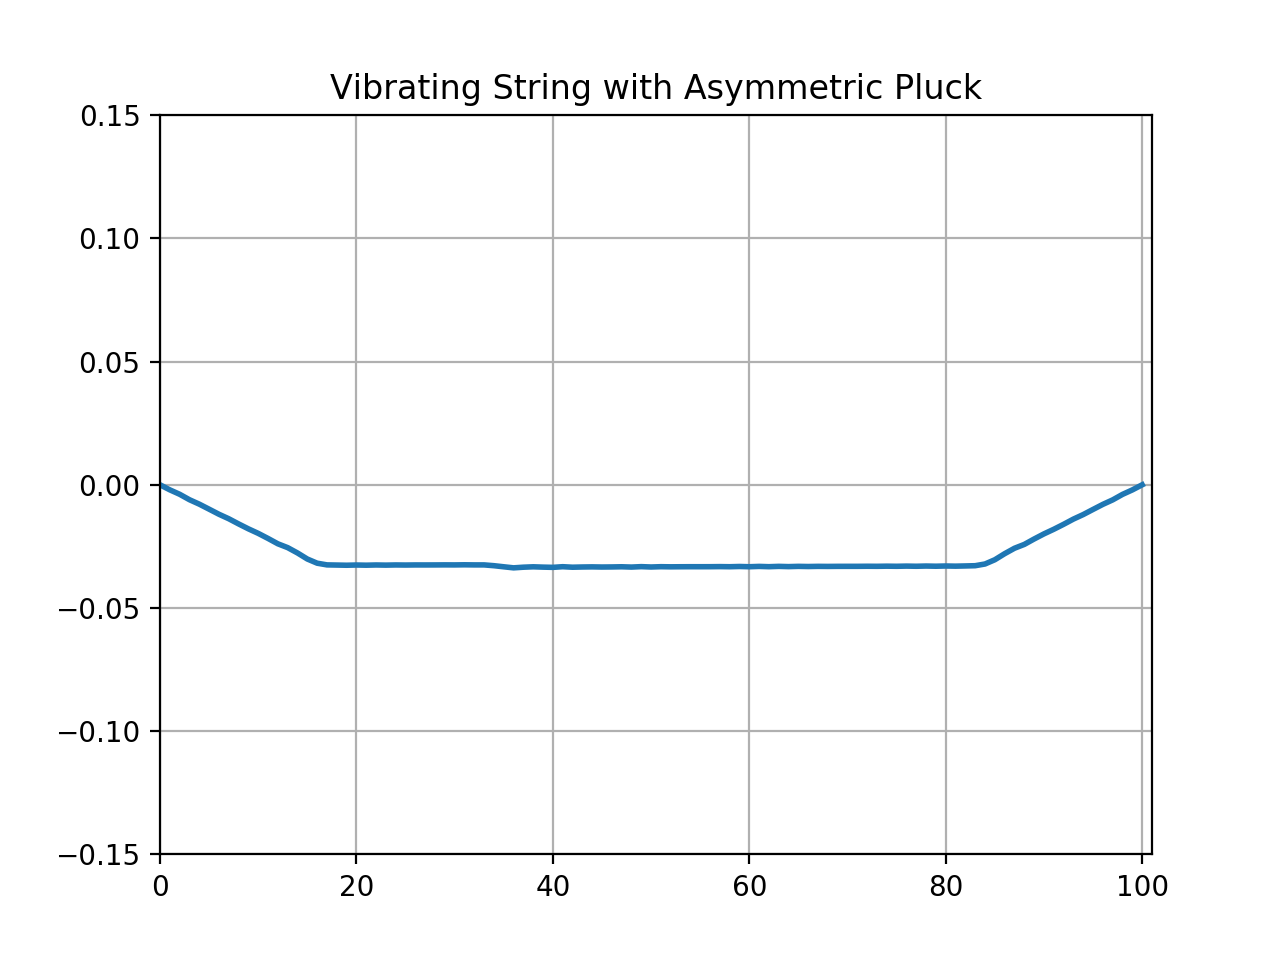

finished


In [6]:
#exploring a different wavelength, L = 65
#Symmetric pluck

%matplotlib notebook
import matplotlib.animation as animation

# Parameters
N = 101
L=65        #length input parameter
x=np.linspace(0,L,N)    #x, steps array
t=np.linspace(0,100,N*100)    #t, steps array
delx=x[1]-x[0]     #calculating delta x for Courant condition
delt=t[1]-t[0]     #calculating delta t for Courant condition
mu = 0.01                               # string density
ten = 40.                               # string tension
c = np.sqrt(ten/mu)                     # propagation speed
c1 = delx/delt    #CFL criterion
print (c/c1)      #g^n(k) < 1. This ration is printed below.
ratio =  c*c/(c1*c1)

# Initialization
xi = np.zeros( (N, 3), float)           # N x's & 3 t's to save memory (only need 3 times for algorithm)
k=range(0,N)
ipluck=0.5    #symmetric pluck
def init():
    for i in range(0, int(ipluck*N)):
        xi[i, 0] = 0.1*i/int(ipluck*N)          # Initial condition: string plucked,shape
    for i in range (int(ipluck*N), N):                           # first part of string
        xi[i, 0] = 0.1 - 0.1/(N*(1-ipluck))*(i - int(ipluck*N))                 # second part of string

init()                                     # plot string initial position   
fig=plt.figure()                           # figure to plot (a changing line)
# select axis; 111: only one plot, x,y, scales given
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, N), ylim=(-0.15, 0.15))
ax.grid()                                                       # plot a grid
plt.title("Vibrating String with Asymmetric Pluck")
line, = ax.plot(k, xi[k,0], lw=2)             # x axis, y values, linewidth=2     

# Later time steps   CORE ALGORITHM
for i in range(1, N-1):                                      # use  algorithm
    xi[i, 1] = xi[i, 0] + 0.5*ratio*(xi[i + 1, 0] + xi[i - 1, 0] - 2*xi[i, 0])   

def animate(num):               #num: dummy,  algorithm, will plot (x, xi)            
    for i in range(1, N-1):              
        xi[i,2] = 2.*xi[i,1]-xi[i,0]+ratio*(xi[i+1,1]+xi[i-1,1]-2*xi[i,1])
    line.set_data(k,xi[k,2])                              # data to plot ,x,y           
    for m in range (0,N):                               # part of algorithm
        xi[m, 0] = xi[m, 1]                               # recycle array 
        xi[m, 1] = xi[m, 2]
    return line,
# next: animation(figure, function,dummy argument: 1      
ani = animation.FuncAnimation(fig, animate,1)           
plt.show()             
print("finished")

The symmetric string pluck behaves as expected. We see that the pluck in the center of the string causes a symmetric 1st mode standing wave to form. It's also noticable that the string behaves more realistically and vibrates around slightly throughout its trajectory because of the set Courant stability condition.

I played around with different wavelength values and found the wave to blow up for values less than around L = 62. This is because the CFL stability criteria is not met for these string length values with the corresponding time array. 

It was also nice to confirm that for longer string lengths, we see the oscillation happens much slower than for shorter wavelengths as expected. 

Interesting initial condition:

I have tested around with different forms of the first initial condition and here made the condition equal to  $0.1sin(\pi x/L)$.


<IPython.core.display.Javascript object>


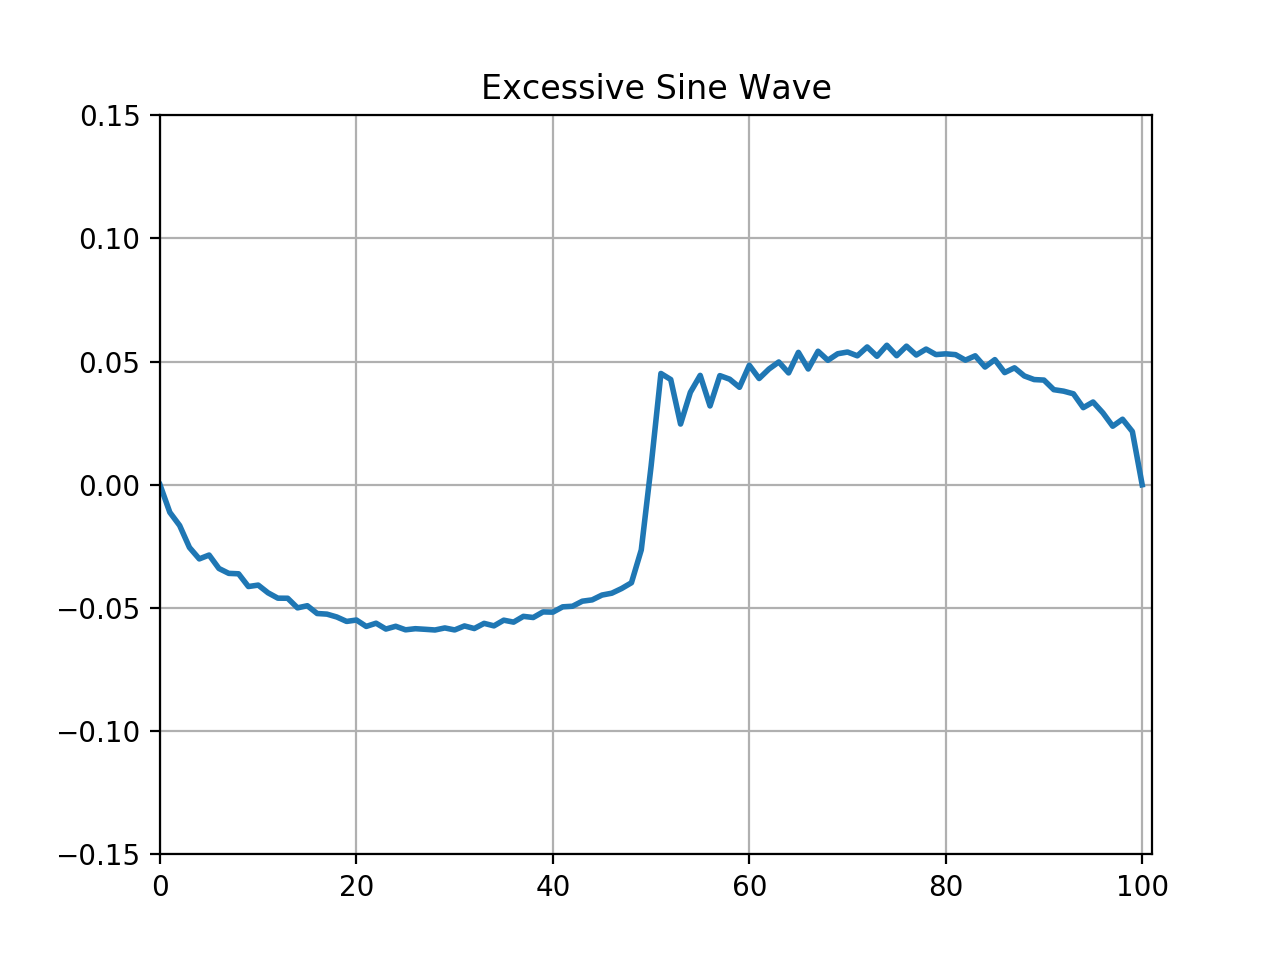

finished


In [7]:
%matplotlib notebook
import matplotlib.animation as animation

# Parameters (in problem set 5, you'll add L and derive the x and t steps from N and CFL)
N = 101
L=65
x=np.linspace(0,L,N)
t=np.linspace(0,100,N*100)
delx=x[1]-x[0]
delt=t[1]-t[0]
mu = 0.01                                                # string density
ten = 40.                                                  # string tension
c = np.sqrt(ten/mu)                                       # Propagation speed
c1 = delx/delt                                               # CFL criterion. You'll make better use of this in Problem set 5.
ratio =  c*c/(c1*c1)
# Initialization
xi = np.zeros( (N, 3), float)                    # N x's & 3 t's to save memory (only need 3 times for algorithm)
k=range(0,N)
ipluck=0.5   #back to asymmetric pluck
def init():
    for i in range(0, int(N/2)):
        xi[i, 0] = .1*np.sin(np.pi*i/L)     # Initial condition: string plucked,shape
    for i in range (int(ipluck*N), N):                           # first part of string
        xi[i, 0] = 0.03 - .1/(N*(1-ipluck))*(i - int(ipluck*N))                 # second part of string

init()                                     # plot string initial position   
fig=plt.figure()                           # figure to plot (a changing line)
# select axis; 111: only one plot, x,y, scales given
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, N), ylim=(-0.15, 0.15))
ax.grid()                                                       # plot a grid
plt.title("Excessive Sine Wave")
line, = ax.plot(k, xi[k,0], lw=2)             # x axis, y values, linewidth=2     

# Later time steps
for i in range(1, N-1):                                      # use  algorithm
    xi[i, 1] = xi[i, 0] + 0.5*ratio*(xi[i + 1, 0] + xi[i - 1, 0] - 2*xi[i, 0])   

def animate(num):               #num: dummy,  algorithm, will plot (x, xi)            
    for i in range(1, N-1):              
        xi[i,2] = 2.*xi[i,1]-xi[i,0]+ratio*(xi[i+1,1]+xi[i-1,1]-2*xi[i,1])
    line.set_data(k,xi[k,2])                              # data to plot ,x,y           
    for m in range (0,N):                               # part of algorithm
        xi[m, 0] = xi[m, 1]                               # recycle array 
        xi[m, 1] = xi[m, 2]
    return line,
# next: animation(figure, function,dummy argument: 1      
ani = animation.FuncAnimation(fig, animate,1)           
plt.show()             
print("finished")

I thought this was interesting as this sinusoidal initial condition demonstrates lots of constructive and destructiver interference taking place as the wave evolves. 
We see that the standing wave bounces back and forth off the two ends and the wave itself is sinusoidal with constantly changing amplitudes. 

Again if L is less than around 62 the stability condition is violated and the wave blows up. Confirming that the solution gets worse for smaller space steps unless accompanied by smaller time steps too. 

Deliberately violating the Courant stability condition:

<IPython.core.display.Javascript object>


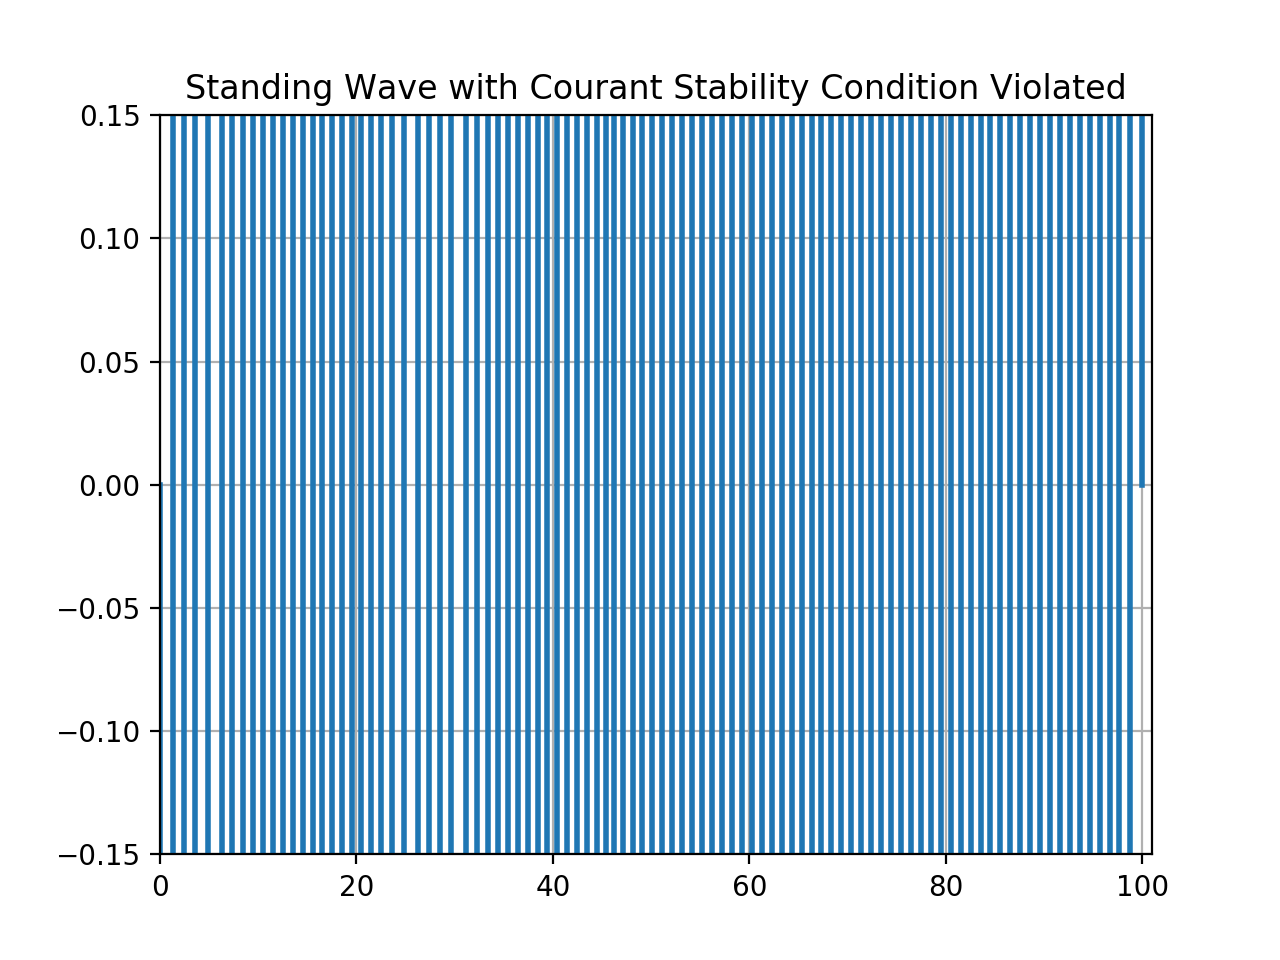

finished


In [8]:
%matplotlib notebook
import matplotlib.animation as animation

N = 101
L=100
x=np.linspace(0,L,N)
t=np.linspace(0,100,N*5)    ##setting bigger time steps than before
delx=x[1]-x[0]
delt=t[1]-t[0]
mu = 0.01                                           # string density
ten = 40.                                           # string tension
c = np.sqrt(ten/mu)                                 # Propagation speed
c1 = delx/delt                                      # CFL criterion. 
ratio =  c*c/(c1*c1)
# Initialization
xi = np.zeros( (N, 3), float)                    # N x's & 3 t's to save memory (only need 3 times for algorithm)
k=range(0,N)
ipluck=0.8
def init():
    for i in range(0, int(ipluck*N)):
        xi[i, 0] = 0.1*i/int(ipluck*N)          # Initial condition: string plucked,shape
    for i in range (int(ipluck*N), N):                              # first part of string
        xi[i, 0] = 0.1 - 0.1/(N*(1-ipluck))*(i - int(ipluck*N))     # second part of string

init()                                     # plot string initial position   
fig=plt.figure()                           # figure to plot (a changing line)
# select axis; 111: only one plot, x,y, scales given
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, N), ylim=(-0.15, 0.15))
ax.grid()                                                       # plot a grid
plt.title("Standing Wave with Courant Stability Condition Violated")
line, = ax.plot(k, xi[k,0], lw=2)             # x axis, y values, linewidth=2     

# Later time steps
for i in range(1, N-1):                                      # use  algorithm
    xi[i, 1] = xi[i, 0] + 0.5*ratio*(xi[i + 1, 0] + xi[i - 1, 0] - 2*xi[i, 0])   

def animate(num):               #num: dummy,  algorithm, will plot (x, xi)            
    for i in range(1, N-1):              
        xi[i,2] = 2.*xi[i,1]-xi[i,0]+ratio*(xi[i+1,1]+xi[i-1,1]-2*xi[i,1])
    line.set_data(k,xi[k,2])                              # data to plot ,x,y           
    for m in range (0,N):                               # part of algorithm
        xi[m, 0] = xi[m, 1]                               # recycle array 
        xi[m, 1] = xi[m, 2]
    return line,
# next: animation(figure, function,dummy argument: 1      
ani = animation.FuncAnimation(fig, animate,1)           
plt.show()             
print("finished")

I have made the time steps much larger. This violates the Courant stability condition as we can see. All parts of the string essentially blow up from the beginning, making each part of the string thinner until the string blows up and dissapears!
The same result can be obtained by instead making the string length much smaller. 